In [1]:
import numpy as np
import pandas as pd
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import pystan
import stan_utility
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [2]:
year = [1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985]
fatal_accidents = [24, 25, 31, 31, 22, 21, 26, 20, 16, 22]
deaths = [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]
death_rate = [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
miles_flown = [3863.0, 4300.0, 5027.0, 5481.0, 5814.0, 6033.0, 5877.0, 6223.0, 7433.0, 7107.0]
data = {'Year' : year, 'Fatal accidents' : fatal_accidents, 'Passenger deaths' : deaths, 'Death rate' : death_rate, 'Miles flown [100 mln miles]' : miles_flown}

data = pd.DataFrame(data).set_index('Year')

data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


1. The rate is constant for all years and not depending on anything.

(array([1., 1., 0., 1., 0., 0., 4., 2., 0., 1.]),
 array([ 223. ,  307.3,  391.6,  475.9,  560.2,  644.5,  728.8,  813.1,
         897.4,  981.7, 1066. ]),
 <a list of 10 Patch objects>)

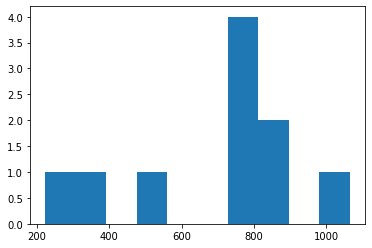

In [3]:
plt.hist(data['Passenger deaths'])

In [4]:
data['Passenger deaths'].mean()

691.9

In [5]:
Lambda = data['Passenger deaths'].mean()

In [6]:
with open('passenger_deaths_ppc.stan', 'r') as file:
    print(file.read())

generated quantities {
    real lambda = normal_rng(692,200);
    int deaths = poisson_rng(lambda);
}


In [7]:
model_ppc=stan_utility.compile_model('passenger_deaths_ppc.stan')

Using cached StanModel


In [8]:
sim_ppc = model_ppc.sampling(data=dict(),
                         iter=1000,
                         warmup=0,
                         refresh=1000,
                         algorithm='Fixed_param',
                         seed=523654)

In [9]:
params_sim=sim_ppc.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

C:\Users\Bartek\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Bartek\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


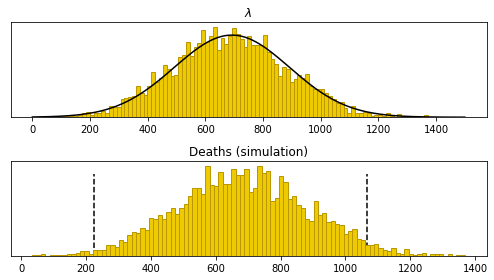

In [10]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([data['Passenger deaths'].min(),data['Passenger deaths'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
ax1.set_title('Deaths (simulation)')

ax2 = fig.add_subplot(gs[0])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=200)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

Result is correct - number of simulated deaths match real data.

In [11]:
with open('passenger_deaths_fit.stan', 'r') as file:
    print(file.read())

data {
    int N; //Number of our samples from data
    int deaths[N]; //Our deaths per year from data
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,200);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death = poisson_rng(lambda);
}


In [12]:
model_fit=stan_utility.compile_model('passenger_deaths_fit.stan')

Using cached StanModel


In [13]:
fit=model_fit.sampling(data=dict(N=len(data['Passenger deaths']),
                                 deaths=data['Passenger deaths']),
                       seed=523654)

In [14]:
az.summary(fit,var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.75,7.99,676.19,706.13


In [15]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['death']

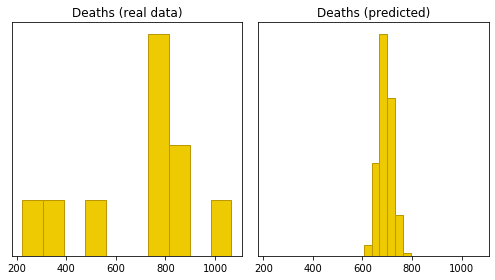

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax=axes[0]
ax.hist(data['Passenger deaths'],color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Deaths (real data)')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=6,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Deaths (predicted)')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

Prediction does not cover the real data. We can see that prediction is focused in range from 600 to 800 whereas the real data is wider. It is hard to create good prediction with this little data. What matches is the probability of the biggest death rate.

2. The intensity is constant, but rate is a product of intensity and miles flown.

In [17]:
intensity = data['Death rate'].mean()
intensity

0.126

In [18]:
with open('passenger_deaths_rate_ppc.stan', 'r') as file:
    print(file.read())

data {
    int N;
    real Miles[N];
}

generated quantities {
    real beta = beta_rng(2,10); //intensity
    int deaths[N];
    for(i in 1:N) {
        deaths[i] = poisson_rng(Miles[i]*beta);
    }

}


In [19]:
model_ppc_rate=stan_utility.compile_model('passenger_deaths_rate_ppc.stan')

Using cached StanModel


In [20]:
data_sim=dict(N=50,
              Miles=np.linspace(data['Miles flown [100 mln miles]'].min(),
                                data['Miles flown [100 mln miles]'].max()))
                                   
rate_sim = model_ppc_rate.sampling(data=data_sim,
                                   iter=1000,
                                   warmup=0,
                                   chains=1,
                                   refresh=1000,
                                   algorithm='Fixed_param',
                                   seed=523654)

In [21]:
params_rate_sim=rate_sim.extract()
beta_sim=params_rate_sim['beta']

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


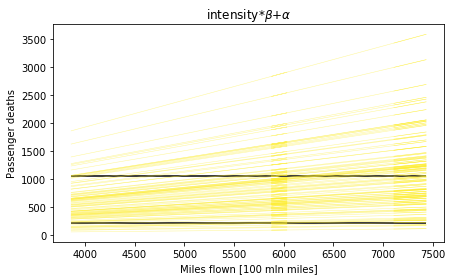

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([data['Passenger deaths'].min(),
             data['Passenger deaths'].max()],
            xmin=data['Miles flown [100 mln miles]'].min(),
            xmax=data['Miles flown [100 mln miles]'].max(),
            colors='black')
for i in range(100):
    axes.plot(data['Miles flown [100 mln miles]'],
              beta_sim[i]*data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,
              linewidth=0.5)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
axes.set_title(r'intensity*$\beta$+$\alpha$')
plt.show()

Most of the estimations fit mentioned conditions.

In [23]:
deaths_rate_sim=params_rate_sim['deaths']

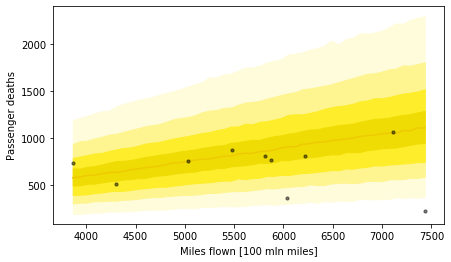

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(7,4))
axes = ribbon_plot(data_sim['Miles'],deaths_rate_sim,axes)
axes.scatter(data['Miles flown [100 mln miles]'],
             data['Passenger deaths'],
             color='black',
             alpha=0.5,
             s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
plt.show()

Almost all of the samples are covered by our prior model.

In [25]:
with open('passenger_deaths_rate_fit.stan', 'r') as file:
    print(file.read())

data {
    int N;
    int deaths[N];
    vector[N] Miles;
}

parameters{
    real beta;
}

transformed parameters {
    vector[N] lambda = Miles*beta;
}

model {
    beta ~ beta(2,10);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death[N];
    for (i in 1:N) {
        death[i] = poisson_rng(lambda[i]);
    }

}


In [26]:
model_rate_fit = stan_utility.compile_model('passenger_deaths_rate_fit.stan')

Using cached StanModel


In [27]:
data_fit=dict(N=len(data),
              deaths=data['Passenger deaths'],
              Miles=data['Miles flown [100 mln miles]'])

rate_fit=model_rate_fit.sampling(data=data_fit,
                                 seed=523654)

In [28]:
params_rate_fit=rate_fit.extract()
beta_rate_fit=params_rate_fit['beta']
lambda_rate_fit=params_rate_fit['lambda']
deaths_rate_pred=params_rate_fit['death']

In [29]:
az.summary(rate_fit,
           var_names=['beta', 'lambda'],
           round_to=2,
           kind='stats')

,mean,sd,hpd_3%,hpd_97%
beta,0.12,0.00,0.12,0.12
lambda[0],467.44,5.65,457.40,478.73
lambda[1],520.32,6.29,509.15,532.88
lambda[2],608.29,7.36,595.23,622.98
lambda[3],663.23,8.02,648.99,679.24
lambda[4],703.52,8.51,688.42,720.51
lambda[5],730.02,8.83,714.35,747.65
lambda[6],711.14,8.60,695.88,728.32
lambda[7],753.01,9.11,736.84,771.19
lambda[8],899.43,10.88,880.12,921.14


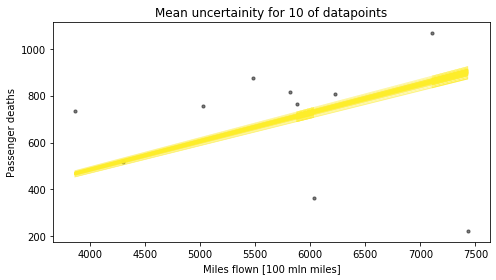

In [30]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True)
for i in range(100):
    axes.plot(data['Miles flown [100 mln miles]'],
              beta_rate_fit[i]*data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,
              linewidth=0.5)
axes.scatter(data['Miles flown [100 mln miles]'],data['Passenger deaths'],color='black',alpha=0.5,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Mean uncertainity for {} of datapoints'.format(len(data)))
fig.tight_layout()
plt.show()

Sorting


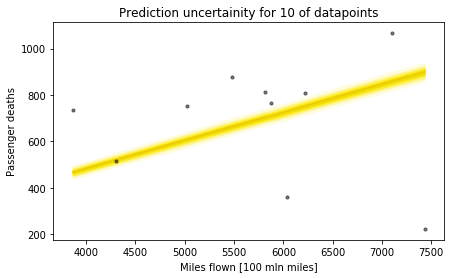

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(data['Miles flown [100 mln miles]'].values,deaths_rate_pred,axes)
axes.scatter(data['Miles flown [100 mln miles]'],data['Passenger deaths'],color='black',alpha=0.5,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(data)))
plt.show()

We can see that data is much better covered but it still needs improvements as our model is based on small dataset.